<a href="https://colab.research.google.com/github/metalnom/Colab_01/blob/master/note02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 구현
- 은닉층 활성화 함수: ReLU
- 출력층 활성화 함수: Softmax
- 손실 함수: 교차 엔트로피 오차
- 최적화 알고리즘: 확률적 경사 하강법
- 배치 사이즈: 8
- 은닉층의 뉴런 수: 25
- input_data는 평균 0, 표준편차 1로 표준화
- correct_data는 원핫인코딩

Epoch: 0/1000 Error_train: 1.1054579556043507 Error_test: 1.1068861388592517
Epoch: 100/1000 Error_train: 0.02431935398597411 Error_test: 0.0707212982957749
Epoch: 200/1000 Error_train: 0.007067181647297938 Error_test: 0.07809445184891022
Epoch: 300/1000 Error_train: 0.0029736137126576694 Error_test: 0.09300415054630724
Epoch: 400/1000 Error_train: 0.001666042877896335 Error_test: 0.10572495870594074
Epoch: 500/1000 Error_train: 0.0010990505063556218 Error_test: 0.1161884111578761
Epoch: 600/1000 Error_train: 0.0007957499866313015 Error_test: 0.1254764439467246
Epoch: 700/1000 Error_train: 0.0006090692941230143 Error_test: 0.13449392725307743
Epoch: 800/1000 Error_train: 0.0004909085394584376 Error_test: 0.14205101795176198
Epoch: 900/1000 Error_train: 0.0004074638327183044 Error_test: 0.14848638064951647


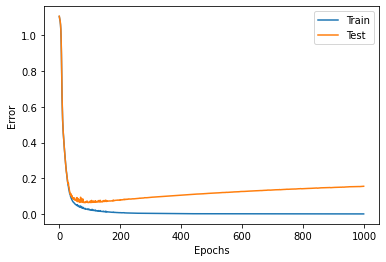

Accuracy Train:  100.0% Accuracy Test:  92.0%


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# iris 데이터 읽기
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

# 입력 데이터 표준화
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

# 정답 데이터를 원핫인코딩
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
  correct_data[i, correct[i]] = 1.0

# 데이터 분리
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

  def update(self, eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b


class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u <= 0, 0, self.u)

  def backward(self, grad_y):
    delta = grad_y * np.where(self.u <= 0, 0, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)

  def backward(self, t):
    delta = self.y - t
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


# 층 초기화
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)


def forward_propagation(x):
  middle_layer_1.forward(x)
  middle_layer_2.forward(middle_layer_1.y)
  output_layer.forward(middle_layer_2.y)

def backpropagation(t):
  output_layer.backward(t)
  middle_layer_2.backward(output_layer.grad_x)
  middle_layer_1.backward(middle_layer_2.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

def get_error(t, batch_size):
  return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size


train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []



n_batch = n_train // batch_size
for i in range(epoch):
  forward_propagation(input_train)
  error_train = get_error(correct_train, n_train)
  forward_propagation(input_test)
  error_test = get_error(correct_test, n_test)

  test_error_x.append(i)
  test_error_y.append(error_test)
  train_error_x.append(i)
  train_error_y.append(error_train)

  if i%interval == 0:
    print("Epoch: " + str(i) + "/" + str(epoch),
          "Error_train: " + str(error_train),
          "Error_test: " + str(error_test))

  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index, :]
    t = correct_train[mb_index, :]

    forward_propagation(x)
    backpropagation(t)

    update_wb()

plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show() 

forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == 
                     np.argmax(correct_train, axis=1))
forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == 
                    np.argmax(correct_test, axis=1))

print("Accuracy Train: ", str(count_train/n_train*100) + "%",
      "Accuracy Test: ", str(count_test/n_test*100) + "%")

# 아다그라드 구현
- BaseLayer 클래스 수정

Epoch: 0/1000 Error_train: 1.0955146768790405 Error_test: 1.0976658385017235
Epoch: 100/1000 Error_train: 0.058506431633717625 Error_test: 0.08892478628510041
Epoch: 200/1000 Error_train: 0.034072503552856015 Error_test: 0.07680747349590401
Epoch: 300/1000 Error_train: 0.025007745399546966 Error_test: 0.0736154942068281
Epoch: 400/1000 Error_train: 0.01985754660795579 Error_test: 0.07180685867451626
Epoch: 500/1000 Error_train: 0.016388453718142147 Error_test: 0.07233661809644236
Epoch: 600/1000 Error_train: 0.013777670158982102 Error_test: 0.0712994562183332
Epoch: 700/1000 Error_train: 0.011745919170823467 Error_test: 0.07123415975879327
Epoch: 800/1000 Error_train: 0.010111384025819166 Error_test: 0.07233305817744838
Epoch: 900/1000 Error_train: 0.008808866329258739 Error_test: 0.07336062338466857


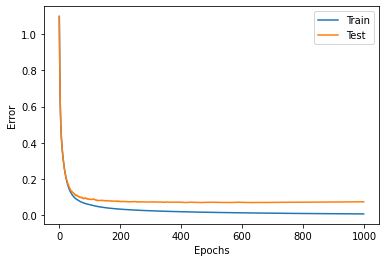

Accuracy Train:  100.0% Accuracy Test:  97.33333333333334%


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# iris 데이터 읽기
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

# 입력 데이터 표준화
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

# 정답 데이터를 원핫인코딩
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
  correct_data[i, correct[i]] = 1.0

# 데이터 분리
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)
    self.h_w = np.zeros((n_upper, n)) + 1e-8
    self.h_b = np.zeros(n) + 1e-8

  def update(self, eta):
    self.h_w += self.grad_w * self.grad_w
    self.w -= eta / np.sqrt(self.h_w) * self.grad_w
    self.h_b += self.grad_b * self.grad_b
    self.b -= eta / np.sqrt(self.h_b) * self.grad_b


class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u <= 0, 0, self.u)

  def backward(self, grad_y):
    delta = grad_y * np.where(self.u <= 0, 0, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)

  def backward(self, t):
    delta = self.y - t
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


# 층 초기화
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)


def forward_propagation(x):
  middle_layer_1.forward(x)
  middle_layer_2.forward(middle_layer_1.y)
  output_layer.forward(middle_layer_2.y)

def backpropagation(t):
  output_layer.backward(t)
  middle_layer_2.backward(output_layer.grad_x)
  middle_layer_1.backward(middle_layer_2.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

def get_error(t, batch_size):
  return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size


train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []



n_batch = n_train // batch_size
for i in range(epoch):
  forward_propagation(input_train)
  error_train = get_error(correct_train, n_train)
  forward_propagation(input_test)
  error_test = get_error(correct_test, n_test)

  test_error_x.append(i)
  test_error_y.append(error_test)
  train_error_x.append(i)
  train_error_y.append(error_train)

  if i%interval == 0:
    print("Epoch: " + str(i) + "/" + str(epoch),
          "Error_train: " + str(error_train),
          "Error_test: " + str(error_test))

  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index, :]
    t = correct_train[mb_index, :]

    forward_propagation(x)
    backpropagation(t)

    update_wb()

plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show() 

forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == 
                     np.argmax(correct_train, axis=1))
forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == 
                    np.argmax(correct_test, axis=1))

print("Accuracy Train: ", str(count_train/n_train*100) + "%",
      "Accuracy Test: ", str(count_test/n_test*100) + "%")

# 드롭아웃 구현
- 드롭아웃 클래스 추가

Epoch: 0/1000 Error_train: 1.0989473357372102 Error_test: 1.0992051320052938
Epoch: 100/1000 Error_train: 0.1691926587771478 Error_test: 0.16611364845069926
Epoch: 200/1000 Error_train: 0.06090459724362363 Error_test: 0.07963110463349525
Epoch: 300/1000 Error_train: 0.044372238232111366 Error_test: 0.07634909566679002
Epoch: 400/1000 Error_train: 0.02819400357689067 Error_test: 0.08236742492722432
Epoch: 500/1000 Error_train: 0.02064693826801564 Error_test: 0.08665180457633563
Epoch: 600/1000 Error_train: 0.017547146801791896 Error_test: 0.08830577344632683
Epoch: 700/1000 Error_train: 0.029833442423343477 Error_test: 0.09692585883043144
Epoch: 800/1000 Error_train: 0.018336873983706693 Error_test: 0.10784912860236981
Epoch: 900/1000 Error_train: 0.013771028324492602 Error_test: 0.1117171152725593


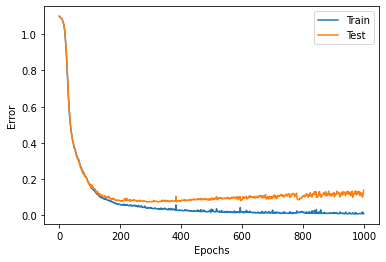

Accuracy Train:  100.0% Accuracy Test:  97.33333333333334%


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# iris 데이터 읽기
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

# 입력 데이터 표준화
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

# 정답 데이터를 원핫인코딩
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
  correct_data[i, correct[i]] = 1.0

# 데이터 분리
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

  def update(self, eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b


class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u <= 0, 0, self.u)

  def backward(self, grad_y):
    delta = grad_y * np.where(self.u <= 0, 0, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)

  def backward(self, t):
    delta = self.y - t
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


class Dropout:
  def __init__(self, dropout_ratio):
    self.dropout_ratio = dropout_ratio
  
  def forward(self, x, is_train):
    if is_train:
      rand = np.random.rand(*x.shape)
      self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
      self.y = x * self.dropout
    else:
      self.y = (1-self.dropout_ratio)*x
  
  def backward(self, grad_y):
    self.grad_x = grad_y * self.dropout


# 층 초기화
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)


def forward_propagation(x, is_train):
  middle_layer_1.forward(x)
  dropout_1.forward(middle_layer_1.y, is_train)
  middle_layer_2.forward(dropout_1.y)
  dropout_2.forward(middle_layer_2.y, is_train)
  output_layer.forward(dropout_2.y)

def backpropagation(t):
  output_layer.backward(t)
  dropout_2.backward(output_layer.grad_x)
  middle_layer_2.backward(dropout_2.grad_x)
  dropout_1.backward(middle_layer_2.grad_x)
  middle_layer_1.backward(dropout_1.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

def get_error(t, batch_size):
  return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size


train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []



n_batch = n_train // batch_size
for i in range(epoch):
  forward_propagation(input_train, False)
  error_train = get_error(correct_train, n_train)
  forward_propagation(input_test, False)
  error_test = get_error(correct_test, n_test)

  test_error_x.append(i)
  test_error_y.append(error_test)
  train_error_x.append(i)
  train_error_y.append(error_train)

  if i%interval == 0:
    print("Epoch: " + str(i) + "/" + str(epoch),
          "Error_train: " + str(error_train),
          "Error_test: " + str(error_test))

  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index, :]
    t = correct_train[mb_index, :]

    forward_propagation(x, True)
    backpropagation(t)

    update_wb()

plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show() 

forward_propagation(input_train, False)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == 
                     np.argmax(correct_train, axis=1))
forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == 
                    np.argmax(correct_test, axis=1))

print("Accuracy Train: ", str(count_train/n_train*100) + "%",
      "Accuracy Test: ", str(count_test/n_test*100) + "%")

In [41]:
samples = np.array([[5.0, 3.5, 1.0, 0.5],
                    [5.5, 2.5, 4.0, 1.0],
                    [7.0, 3.0, 6.0, 2.0],
                    [6.6, 2.5, 1.5, 0.2]])
ave_input = np.average(samples, axis=0)
std_input = np.std(samples, axis=0)
samples = (samples - ave_input) / std_input

forward_propagation(samples, False)
print(output_layer.y)

[[1.00000000e+00 2.55796371e-20 5.92423286e-18]
 [6.60673295e-03 9.80537616e-01 1.28556510e-02]
 [1.06041408e-22 5.01610236e-24 1.00000000e+00]
 [9.96012490e-01 3.91234304e-03 7.51670023e-05]]


In [49]:
output_arr = np.zeros((output_layer.y.shape))
for i in range(output_layer.y.shape[0]):
  output_arr[i][np.argmax(output_layer.y[i])] = 1.0
print(output_arr)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
